In [1]:
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from datetime import datetime as dt
import pandas as pd
import numpy as np
import random

In [2]:
DATA_PATH = "../../data/02_intermediate/"

In [3]:
def cc(arg):
    return mcolors.to_rgba(arg, alpha=0.6)

def all_colors():
    return ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan",
            "b", "g", "r", "c", "m", "y", "k",
            "limegreen", "cornflowerblue", "mediumblue", "darkorange", "maroon", "deepskyblue", "darkmagenta"]

def random_color():
    pallette = all_colors()
    return cc(random.choice(pallette))

def get_color(index):
    pallette = all_colors()
    return cc(pallette[index])

def all_lines():
    return ["-", "--", "-.", "."]

def all_markers():
    return [".", ",", "o", "v", "^", "1", "8", "*", "H", "d"]

def random_marker():
    return random.choice(all_markers())

In [4]:
def custom_scatter_2D(matrix, labels, cluster_centers, n_clusters, digit, coeffs=[0, 1]):
    """Scatter plot of 2 dimensions of kmeans results"""
    fig = plt.figure()
    ax = fig.add_subplot()

    clustered_matrix = parse_labels(matrix=matrix, labels=labels, n_clusters=n_clusters)
    # for cluster in clustered_matrix:
    for index in range(len(clustered_matrix)):
        cluster = clustered_matrix[index]
        xs = cluster[:, coeffs[0]]
        ys = cluster[:, coeffs[1]]
        ax.scatter(x=xs, y=ys, s=0.5, color=get_color(index=index), marker=random_marker())
    
    ax.set_xlabel(f"MFCC {coeffs[0]}")
    ax.set_ylabel(f"MFCC {coeffs[1]}")
    ax.set_title(f"K-Means Result for Digit {digit} with {n_clusters} Clusters")

    plt.show()

In [5]:
def create_filter_arr(labels, cluster):
    """Create boolean flagged filter array to apply to filter np array"""
    filter_arr = []
    for label in labels:
        if label == cluster:
            filter_arr.append(True)
        else:
            filter_arr.append(False)
    return filter_arr

def parse_labels(matrix, labels, n_clusters):
    """Filter matrix and labels into clustered matrices for scatter plotting"""
    clustered_matrix = []

    for cluster in range(n_clusters):
        filter_arr = create_filter_arr(labels=labels, cluster=cluster)
        sub_matrix = matrix[filter_arr]
        clustered_matrix.append(sub_matrix)

    return clustered_matrix

def analyze_cluster(matrix, labels, cluster_centers, n_clusters):
    """Compute covariance and pi value for gmm vars of clusters"""
    covariance_matrix = []
    pi_matrix = []

    for cluster in range(n_clusters):
        filter_arr = create_filter_arr(labels=labels, cluster=cluster)
        sub_matrix = matrix[filter_arr]

        pi = len(sub_matrix) / len(matrix)
        covariance = np.cov(np.transpose(sub_matrix))

        pi_matrix.append(pi)
        covariance_matrix.append(covariance)
        
    return (covariance_matrix, pi_matrix)

In [6]:
class GaussParams:
    """ Gaussian Mixture Model object to encapsulate params """
    def __init__(self, u, pi, cov):
        self.u = u
        self.pi = pi
        self.cov = cov

    def __str__(self):
        return f"u: {self.u}\npi: {self.pi}\ncov: {self.cov}"

In [7]:
def create_model(digits, clusters, model_coeffs, train_path):
    """
    Create a gaussian mixture model from parameters
    digits - max digit to train through
    cluters - array of clutser counts (indexed by digit)
    model_coeffs - range of model coefficients to use for modeling
    train_path - relative path to training data
    """
    gauss_results = []
    for digit in range(digits):
        # Read in train file and parse as dataframe
        filename = f"{train_path}{digit}.txt"
        df = pd.read_csv(filename, skip_blank_lines=True, delimiter=' ', header=None)
        df.dropna(axis=0, inplace=True)

        # Filter dataframe down to only model coefficient columns
        df_filter = df.iloc[:, model_coeffs]
        matrix = df_filter.values
        n_clusters = clusters[digit]

        # Apply kmeans on the matrix of values
        kmeans = KMeans(n_clusters=n_clusters, random_state=0)
        kmeans.fit(matrix)
        labels = kmeans.labels_
        cluster_centers = kmeans.cluster_centers_

        # Record the GMM results (u, pi, and cov)
        cluster_covariance, cluster_pi = analyze_cluster(matrix=matrix, labels=labels, cluster_centers=cluster_centers, n_clusters=n_clusters)    
        gauss = GaussParams(u=cluster_centers, pi=cluster_pi, cov=cluster_covariance)
        gauss_results.append(gauss)

        # Visualize the kmeans plot as scatter in 2D
        # custom_scatter_2D(matrix=matrix, labels=labels, cluster_centers=cluster_centers, n_clusters=n_clusters, digit=digit, coeffs=PLOT_COEFFS)
    return gauss_results

In [8]:
def get_pi_df(gauss_results):
    """ Printing probability of ending up in each mixture"""
    pi_vals = []
    for index in range(len(gauss_results)):
        result = gauss_results[index]
        pi_vals.append(result.pi)

    # print(f"PI VALUES FOR GAUSS RESULTS (cluster result x digit)")
    pi_df = pd.DataFrame(pi_vals)
    return pi_df


In [9]:
def get_all_dataframes(digit, write_path, read_path, stopwatch):
    """
    Get all of the dataframes for a single digit 
    Use single_person data folder as intermediary for pandas read csv ease of use
    """
    start_time = dt.now()
    read_filename = f"{read_path}{digit}.txt"
    write_filename = f"{write_path}{digit}.txt"

    f = open(write_filename, "w")
    line_count = 0

    df_all = []

    # Open file and build out data
    with open(read_filename, "r") as file:
        for line in file:
            if len(line.strip()) != 0:
                f.write(line)
                line_count += 1
            elif line_count > 0:
                # Close file descriptor, read in written data, update dataframes
                f.close()
                df = pd.read_csv(write_filename, skip_blank_lines=True, delimiter=' ', header=None)
                df_all.append(df)

                # Reset line count and file descriptor for new dataframe parse
                line_count = 0
                f = open(write_filename, "w")

    # Likely have one more (no missing line on final line)
    if line_count > 0:
        f.close()
        df = pd.read_csv(write_filename, skip_blank_lines=True, delimiter=' ', header=None)
        df_all.append(df)

    end_time = dt.now()
    total_time = (end_time - start_time).total_seconds()

    if (stopwatch):
        print(f"Parsed {len(df_all)} frames in {total_time} sec")

    return df_all
     
def print_summary(digit, total_time, correct, utterances):
    """Output summary from classification to console"""
    accuracy = correct / utterances * 100
    accuracy = round(accuracy, 3)
    dt_format = "%H:%M:%S"
    cur_time = dt.strftime(dt.now(), dt_format) 
    print(f"#{digit}\taccuracy: {accuracy}%\tcorrect: {correct}\tutterances: {utterances}\ttotal_time: {round(total_time, 3)} sec\tcur_time: {cur_time}")

In [10]:
def classify_dataframe(df, gauss_results, digits, model_coeffs):
    """
    Classify a dataframe based on gaussian results
    df - dataframe to classify
    gauss_results - gmm mixture model results
    digits - total digits to validate
    model_coeffs - model coefficients (array)
    """

    # Perform classification on some test data
    posterior_all = []
    for d in range(digits):
        """Iterate over all digits (possible classifications"""
        posterior_digit = 0

        for n, row in df.iterrows():
            """Iterate over all n frames of the sample"""
            frames_n = row.to_numpy()[model_coeffs]

            sum_m = 0
            result_m = gauss_results[d]
            """Iterate over all results from gmm parameters"""
            cov, pi, u = result_m.cov, result_m.pi, result_m.u   

            for m in range(len(u)):
                """Iterate over all m dimensions of mixture model"""
                u_m = u[m]
                cov_m = cov[m]
                pi_m = pi[m]

                y = multivariate_normal.pdf(x=frames_n, mean=u_m, cov=cov_m)
                posterior_i = y * pi_m
                sum_m += posterior_i

            # end sum over all gauss components for digit
            posterior_digit += np.log(sum_m)
            
            # circuit break on underflow, no longer needed with logpdf
            # y = multivariate_normal.pdf(x=frames_n, mean=u_m, cov=cov_m)  # this causes underflow
            if posterior_digit == 0:
                sys.exit()

        # TODO - normalize by the number of samples (is this necessary?)
        # end product of all n frames
        # if (debug):
        #     print(f"digit: {d}\tposterior_digit: {posterior_digit}")
        posterior_all.append(posterior_digit)
    
    classification = posterior_all.index(max(posterior_all))
    return (classification, posterior_all)

In [11]:
def test_model(classify_every, gauss_results, model_coeffs, digits):
    """
    Using previously computed gauss results, test the model
    classify_every - increase for speed (skip values)
    gauss_results - gaussian mixture model parameters
    model_coeffs - coefficients from model used in generation
    digits - total digits to train on
    """

    test_read_path = f"{DATA_PATH}test_digits/test_0"
    test_write_path = f"{DATA_PATH}single_person/test_0"

    classify_results = []
    summary_lists = []
    for digit in range(digits):
        total_classified = 0
        correct = 0
        df_all = get_all_dataframes(digit=digit, write_path=test_write_path, read_path=test_read_path, stopwatch=False)
        classify_digit = [0]*digits

        index = 0
        start_time = dt.now()
        for df in df_all:
            if index % classify_every == 0:
                (classification, posterior_all) = classify_dataframe(df=df, gauss_results=gauss_results, digits=digits, model_coeffs=model_coeffs) 
                total_classified += 1
                classify_digit[classification] += 1
                if classification == digit:
                    correct += 1
            index += 1

        classify_results.append(classify_digit)

        end_time = dt.now()
        total_time = round((end_time - start_time).total_seconds(), 3)
        accuracy = round(correct / total_classified * 100, 3)
        # total_time = f"{total_time} sec"
        # accuracy = f"{accuracy} %"
        summary = [digit, accuracy, correct, total_classified, total_time]
        summary_lists.append(summary)

    summary_df = pd.DataFrame(summary_lists, columns=["Digit", "Accuracy (%)", "Correct", "Classified", "Time (s)"])
    classify_df = pd.DataFrame(classify_results)

    return (summary_df, classify_df)

In [12]:
def name_files(use_coeffs, num_clusters):
    return f"{use_coeffs}mfcc_{num_clusters}clust"
    

In [13]:
# Define all relative file paths to actually get files
TRAIN_PATH = f"{DATA_PATH}train_digits/train_0"
TEST_PATH = f"{DATA_PATH}test_digits/test_0"
WRITE_PATH = f"../../data/03_results/"

PI_SUFFIX = "_pi.csv"
CONF_SUFFIX = "_conf.csv"
RESULTS_SUFFIX = "_results.csv"
SUMMARY_SUFFIX = "_summary.csv"

DIGITS = 10
PLOT_COEFFS = [0, 1]

In [14]:
# use_coeffs = 7
# digits = 10
# model_coeffs = range(use_coeffs)
# num_clusters = 3
# clusters = [num_clusters]*digits
# classify_every = 5

# MAX_CLUSTERS = 8
# for num_clusters in range(1,MAX_CLUSTERS):
#     clusters = [num_clusters]*digits

#     # Run model on parameters
#     gauss_results = create_model(digits=digits, clusters=clusters, model_coeffs=model_coeffs, train_path=TRAIN_PATH)
#     (summary_df, classify_df) = test_model(classify_every=classify_every, gauss_results=gauss_results, model_coeffs=model_coeffs, digits=digits)
#     pi_df = get_pi_df(gauss_results=gauss_results)

#     # Write output files and send useful printout
#     prefix = name_files(use_coeffs=use_coeffs, num_clusters=num_clusters)
#     pi_filename = f"{WRITE_PATH}{prefix}{PI_SUFFIX}"
#     conf_filename = f"{WRITE_PATH}{prefix}{CONF_SUFFIX}"
#     results_filename = f"{WRITE_PATH}{prefix}{RESULTS_SUFFIX}"
#     # summary_filename = f"{WRITE_PATH}{prefix}{SUMMARY_SUFFIX}"

#     # TODO write to datafile
#     print(f"{prefix}: \n{summary_df.mean(axis=0)}\n")
#     summary_df.to_csv(results_filename)
#     classify_df.to_csv(conf_filename)
#     pi_df.to_csv(pi_filename)

In [15]:
# MAX_COEFFS = 11
# digits = 10
# model_coeffs = range(use_coeffs)
# num_clusters = 4
# clusters = [num_clusters]*digits
# classify_every = 5

# for use_coeffs in range(1,MAX_COEFFS):
#     model_coeffs = range(use_coeffs)

#     # Run model on parameters
#     gauss_results = create_model(digits=digits, clusters=clusters, model_coeffs=model_coeffs, train_path=TRAIN_PATH)
#     (summary_df, classify_df) = test_model(classify_every=classify_every, gauss_results=gauss_results, model_coeffs=model_coeffs, digits=digits)
#     pi_df = get_pi_df(gauss_results=gauss_results)

#     # Write output files and send useful printout
#     prefix = name_files(use_coeffs=use_coeffs, num_clusters=num_clusters)
#     pi_filename = f"{WRITE_PATH}{prefix}{PI_SUFFIX}"
#     conf_filename = f"{WRITE_PATH}{prefix}{CONF_SUFFIX}"
#     results_filename = f"{WRITE_PATH}{prefix}{RESULTS_SUFFIX}"
#     # summary_filename = f"{WRITE_PATH}{prefix}{SUMMARY_SUFFIX}"

#     # Useful printout for debug, save files
#     print(f"{prefix}: \n{summary_df.mean(axis=0)}\n")
#     summary_df.to_csv(results_filename)
#     classify_df.to_csv(conf_filename)
#     pi_df.to_csv(pi_filename)

#     txt_out = f"{WRITE_PATH}{num_clusters}clust_out.txt"
#     f = open(txt_out, "a")
#     f.write(f"{prefix}: \n{summary_df.mean(axis=0)}\n\n")
#     f.close()

In [16]:
# avg_accuracy = summary_df["Accuracy (%)"].mean(axis=0)
# print(f"Average Accuracy: {avg_accuracy} %")

# avg_time = summary_df["Time (s)"].mean(axis=0)
# print(f"Average Time (for classified utterances): {avg_time} sec")

# tot_time = summary_df["Time (s)"].sum(axis=0)
# print(f"Total Time: {tot_time} sec")

# tot_classified = summary_df["Classified"].sum(axis=0)
# print(f"Total Classified: {tot_classified}")

# avg_time_utter = tot_time / tot_classified
# print(f"Average Time (per utterance): {round(avg_time_utter, 3)} sec")

# # TODO - mesh grid of accuracy/time per utterance over mfcc/clusters

In [17]:
class MeshResults:
    """ Gaussian Mixture Model object to encapsulate params """
    def __init__(self, accuracy, time, conf, summary, coeffs, clusters):
        self.accuracy = round(accuracy, 3)
        self.time = round(time, 3)
        self.conf = conf
        self.summary = summary
        self.coeffs = coeffs
        self.clusters = clusters

    def __str__(self):
        return f"{self.coeffs} MFFCS\t{self.clusters} clusters\t{self.accuracy} %\t{self.time} seconds/utterance"

In [18]:
def get_accuracy_time(summary_df):
    """
    Get accuracy and time from summary dataframe
    """
    accuracy = summary_df["Accuracy (%)"].mean(axis=0)
    tot_time = summary_df["Time (s)"].sum(axis=0)
    tot_classified = summary_df["Classified"].sum(axis=0)
    time = tot_time / tot_classified
    return (accuracy, time)

In [19]:
# TODO - meshgrid and save mesh_results as pickle
import pickle
import os

def load_serial(filename):
    """
    Load serialized object and return
    """
    pickle_in = open(filename, "rb")
    obj = pickle.load(pickle_in)

    size = os.stat(filename).st_size
    print(f"loaded {size} bytes")

    return obj

def serialize_mesh(obj, filename):
    """
    Use pickle to serialize object and dump in output directory
    """
    pickle_out = open(filename, "wb")
    pickle.dump(obj, pickle_out)
    pickle_out.close()

    size = os.stat(filename).st_size
    print(f"dumped {size} bytes")

In [20]:
MAX_COEFFS = 13
MAX_CLUSTERS = 10

digits = 10
classify_every = 2

mesh_all = []

for use_coeffs in range(1,MAX_COEFFS+1):
    model_coeffs = range(use_coeffs)
    mesh_row = []

    for num_clusters in range(1,MAX_CLUSTERS+1):
        clusters = [num_clusters]*digits
        
        # Run model on parameters
        gauss_results = create_model(digits=digits, clusters=clusters, model_coeffs=model_coeffs, train_path=TRAIN_PATH)
        (summary_df, classify_df) = test_model(classify_every=classify_every, gauss_results=gauss_results, model_coeffs=model_coeffs, digits=digits)
        pi_df = get_pi_df(gauss_results=gauss_results)

        # Pump results into mesh grid
        (accuracy, time) = get_accuracy_time(summary_df=summary_df)
        mesh_results = MeshResults(accuracy=accuracy, time=time, conf=classify_df, summary=summary_df, coeffs=use_coeffs, clusters=num_clusters) 
        mesh_row.append(mesh_results)

        # Write output files and send useful printout
        prefix = name_files(use_coeffs=use_coeffs, num_clusters=num_clusters)

        # Useful printout for debug, save files
        print(f"{prefix}: \n{summary_df.mean(axis=0)}\n")

    # end iteration over cluster count
    mesh_all.append(mesh_row)

    # Serialize periodically so we don't lose data
    SERIAL_PATH = "../../data/04_serial/"
    prefix = name_files(use_coeffs=MAX_COEFFS, num_clusters=MAX_CLUSTERS)
    filename = f"{SERIAL_PATH}{prefix}_kmeans.pickle" # "../../data/04_serial/clust_test.pickle"
    serialize_mesh(obj=mesh_all, filename=filename)

1000
Time (s)         16.7438
dtype: float64

1mfcc_5clust: 
Digit             4.5000
Accuracy (%)     34.4496
Correct          37.9000
Classified      110.1000
Time (s)         20.2346
dtype: float64

1mfcc_6clust: 
Digit             4.5000
Accuracy (%)     34.1787
Correct          37.6000
Classified      110.1000
Time (s)         23.4987
dtype: float64

1mfcc_7clust: 
Digit             4.5000
Accuracy (%)     31.4496
Correct          34.6000
Classified      110.1000
Time (s)         27.2654
dtype: float64

1mfcc_8clust: 
Digit             4.5000
Accuracy (%)     32.9016
Correct          36.2000
Classified      110.1000
Time (s)         29.9734
dtype: float64

1mfcc_9clust: 
Digit             4.5000
Accuracy (%)     31.9041
Correct          35.1000
Classified      110.1000
Time (s)         35.4657
dtype: float64

1mfcc_10clust: 
Digit             4.5000
Accuracy (%)     30.8992
Correct          34.0000
Classified      110.1000
Time (s)         37.5253
dtype: float64

dumped 19407 byte

In [37]:
# Perform final serialization on all objects (not necessary)
SERIAL_PATH = "../../data/04_serial/"

prefix = name_files(use_coeffs=MAX_COEFFS, num_clusters=MAX_CLUSTERS)
filename = f"{SERIAL_PATH}{prefix}_kmeans.pickle" # "../../data/04_serial/clust_test.pickle"
serialize_mesh(obj=mesh_all, filename=filename)
result = load_serial(filename)

# Testing printout of serialized load of results
# for row in result:
#     for col in row:
#         print(col)

dumped 245443 bytes
loaded 245443 bytes


In [52]:
from matplotlib import cm

def plot_results(df, title, xlabel, ylabel, filename):
    """
    From dataframe, plot results (with axes information)
    """
    fig, ax = plt.subplots()
    mfcc_data= np.swapaxes(df, 0 ,1)
    cmap = cm.coolwarm
    norm = mcolors.Normalize(df.to_numpy().min(), df.to_numpy().max())
    fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.coolwarm), ax=ax)
    ax.imshow(mfcc_data, interpolation='nearest', cmap=cmap, origin='lower')
    ax.set_title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.savefig(filename)
    plt.show()

In [34]:
def parse_mesh(mesh_all):
    """
    From mesh results (list of lists), parse accuracy and mean as 2d array
    accuracy_all - accuracy for pairwise combos
    time_all - time per classification
    div_all - accuracy % per second
    """
    accuracy_all, time_all, div_all = [], [], []

    for row in result:
        accuracy_row, time_row, div_row = [], [], []
        for col in row:
            accuracy_row.append(col.accuracy)
            time_row.append(col.time)
            div_row.append(col.accuracy / col.time)

        # end loop over col
        accuracy_all.append(accuracy_row)
        time_all.append(time_row)
        div_all.append(div_row)

    # end loop over rows

    return (accuracy_all, time_all, div_all)

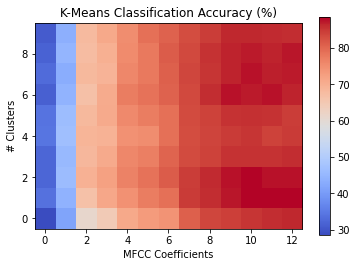

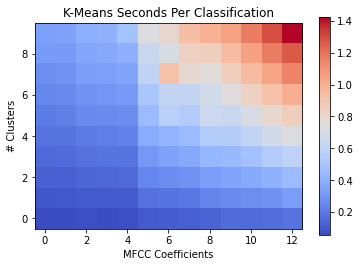

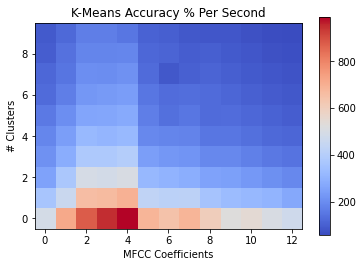

In [54]:
FIG_PATH = "../../data/05_fig/"
RESULTS_PATH = "../../data/03_results/"
prefix = name_files(use_coeffs=MAX_COEFFS, num_clusters=MAX_CLUSTERS)
file_prefix = f"{FIG_PATH}{prefix}_kmeans_" # "../../data/04_serial/clust_test.pickle"

(accuracy_all, time_all, div_all) = parse_mesh(mesh_all)
accuracy_df = pd.DataFrame(accuracy_all)
time_df = pd.DataFrame(time_all)
div_df = pd.DataFrame(div_all)

# Write results to files
accuracy_df.to_csv(f"{RESULTS_PATH}{prefix}_kmeans_accuracy.csv")
time_df.to_csv(f"{RESULTS_PATH}{prefix}_kmeans_time.csv")
div_df.to_csv(f"{RESULTS_PATH}{prefix}_kmeans_div.csv")

# Plot results
plot_results(df=accuracy_df, title=f"K-Means Classification Accuracy (%)", xlabel="MFCC Coefficients", ylabel="# Clusters", filename=f"{file_prefix}accuracy.png")
plot_results(df=time_df, title=f"K-Means Seconds Per Classification", xlabel="MFCC Coefficients", ylabel="# Clusters", filename=f"{file_prefix}time.png")
plot_results(df=div_df, title=f"K-Means Accuracy % Per Second", xlabel="MFCC Coefficients", ylabel="# Clusters", filename=f"{file_prefix}vel.png")